# Importações

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import random 
from scipy import stats

from sklearn.preprocessing    import MinMaxScaler,RobustScaler
from sklearn.model_selection  import train_test_split, StratifiedKFold,RandomizedSearchCV
from sklearn.model_selection  import cross_val_score, cross_validate

from imblearn.combine import SMOTETomek

from sklearn.ensemble         import RandomForestClassifier,ExtraTreesClassifier
from sklearn.linear_model     import LogisticRegression
from xgboost                  import XGBClassifier
from lightgbm                 import LGBMClassifier
from sklearn.neighbors        import KNeighborsClassifier


from sklearn.metrics          import classification_report, cohen_kappa_score, roc_curve, brier_score_loss,roc_auc_score
from sklearn.metrics          import accuracy_score, precision_score,recall_score,confusion_matrix,f1_score,precision_recall_curve

from sklearn.calibration      import CalibratedClassifierCV
from sklearn.calibration      import calibration_curve

In [56]:
pd.set_option('display.max_columns',None)
# pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Funções de Apoio

In [57]:
def ml_metrics( model_name, y_true, yhat):
    accuracy = accuracy_score(y_true, yhat)
    precision = precision_score(y_true, yhat)
    recall = recall_score(y_true, yhat)

    return pd.DataFrame({'Model Name': model_name, 
                        'ACC': accuracy,
                        'PRECISION': precision,
                        'RECALL': recall}, index = [0])

In [58]:
def model_cross_validation(model_name, model, X, y, threshold):
    skf = StratifiedKFold(n_splits=5)
    precision_list = []
    recall_list = []
    f1_list = []
    accuracy_list = []
    kappa_list = []
    auc_score_list = []

    for train_index, test_index in skf.split(X, y):
        x_train_fold, x_test_fold = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train_fold, y_test_fold = y.iloc[train_index,:], y.iloc[test_index,:]

        model.fit(x_train_fold, y_train_fold.values.ravel())
        
        probs = pd.DataFrame(model.predict_proba(x_test_fold)[:, 1], columns=['prob'])
        
        # applies the threshold
        y_hat = probs['prob'].apply(lambda x: 1 if x > threshold else 0)
        
        precision = precision_score(y_test_fold, y_hat)
        recall = recall_score(y_test_fold, y_hat)
        f1 = f1_score(y_test_fold, y_hat)
        accuracy = accuracy_score(y_test_fold, y_hat)
        kappa = cohen_kappa_score(y_test_fold, y_hat)
        auc_score = roc_auc_score(y_test_fold, probs)
        
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        accuracy_list.append(accuracy)
        kappa_list.append(kappa)
        auc_score_list.append(auc_score)


    result = {'Model Name': model_name, 
                'Precision': round(100*np.mean(precision_list),2),
                'Recall': round(100*np.mean(recall_list),2),
                'F1-Score': round(100*np.mean(f1_list),2),
                'Accuracy': round(100*np.mean(accuracy_list),2),
                'Kappa': round(100*np.mean(kappa_list),2),
                'AUC': round(100*np.mean(auc_score_list),2)}
    return pd.DataFrame(result, index = [0])

In [59]:
def cramer_v(x, y):
    cm = pd.crosstab( x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency( cm )[0]

    # correção bias V de Cramer
    chi2corr = max(0, chi2 - (k-1)*(r - 1) / (n-1))
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)

    v = np.sqrt( (chi2corr / n) / (min(kcorr-1, rcorr-1) ) )
    return v

# Carga dos Dados

In [60]:
path = '../data/'

In [61]:
df = pd.read_csv(path + 'Customer-Churn - Customer-Churn.csv',sep = ',')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7569-NMZYQ,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),"118,75","8672,45",No
1,8984-HPEMB,Female,0,No,No,71,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,"118,65","8477,6",No
2,5989-AXPUC,Female,0,Yes,No,68,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Mailed check,"118,6","7990,05",No
3,5734-EJKXG,Female,0,No,No,61,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,"118,6","7365,7",No
4,8199-ZLLSA,Male,0,No,No,67,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),"118,35","7804,15",Yes


# Descrição dos dados

## Renomear colunas

In [62]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

## Dimensão dos dados

In [63]:
print('Quantidade de: \nLinhas: {} \nColunas: {}'.format(df.shape[0],df.shape[1]))

Quantidade de: 
Linhas: 7043 
Colunas: 21


In [64]:
df['Churn'].value_counts(normalize=True)*100

No    73.463
Yes   26.537
Name: Churn, dtype: float64

Temos dados desbalanceados, uma vez que 26,6% dos dados são CHURN

## Tipos de dados

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   gender            7043 non-null   object
 2   SeniorCitizen     7043 non-null   int64 
 3   Partner           7043 non-null   object
 4   Dependents        7043 non-null   object
 5   tenure            7043 non-null   int64 
 6   PhoneService      7043 non-null   object
 7   MultipleLines     7043 non-null   object
 8   InternetService   7043 non-null   object
 9   OnlineSecurity    7043 non-null   object
 10  OnlineBackup      7043 non-null   object
 11  DeviceProtection  7043 non-null   object
 12  TechSupport       7043 non-null   object
 13  StreamingTV       7043 non-null   object
 14  StreamingMovies   7043 non-null   object
 15  Contract          7043 non-null   object
 16  PaperlessBilling  7043 non-null   object
 17  PaymentMethod 

## Verificar NA

In [66]:
df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

11 elementos nulos no TotalCharges

## Mudar o dtypes

In [67]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7569-NMZYQ,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),"118,75","8672,45",No
1,8984-HPEMB,Female,0,No,No,71,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,"118,65","8477,6",No
2,5989-AXPUC,Female,0,Yes,No,68,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Mailed check,"118,6","7990,05",No
3,5734-EJKXG,Female,0,No,No,61,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,"118,6","7365,7",No
4,8199-ZLLSA,Male,0,No,No,67,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),"118,35","7804,15",Yes


In [68]:
df['Churn'].unique()

array(['No', 'Yes'], dtype=object)

In [69]:
# mudança nas variaveis string que possuem valores que se identificam como "No", porém escritos de outra forma (como "no phone")
cols_a_mudar = ['StreamingMovies','StreamingTV','MultipleLines','OnlineBackup','OnlineSecurity','DeviceProtection','TechSupport']

for i in cols_a_mudar:
    df.loc[df[i] != 'Yes', i ] = 'No'

In [70]:
# mudança das colunas que são float, porém vieram como string
for i in ['MonthlyCharges','TotalCharges']:
    df[i] = df[i].str.replace('.','').str.replace(',','.').astype(float)

## Replace NA

In [71]:
print("Antes do drop: {}".format(df.shape))

df = df.dropna()

print("Depois do drop: {}".format(df.shape))

Antes do drop: (7043, 21)
Depois do drop: (7032, 21)


## Estatística Descritiva

In [72]:
df1 = df.copy()

### Atributos Numéricos

In [73]:
num_attributes = df1.select_dtypes(include=['int64','float64'])

In [74]:
# tendencias centrais
ct_mean = pd.DataFrame( num_attributes.apply( np.mean )).T
ct_median = pd.DataFrame( num_attributes.apply( np.median )).T

# dispesão
ct_std = pd.DataFrame( num_attributes.apply( np.std )).T
ct_min = pd.DataFrame( num_attributes.apply( np.min )).T
ct_max = pd.DataFrame( num_attributes.apply( np.max )).T
ct_range = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
ct_skew = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
ct_kurtosis = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

In [75]:
num_analysis = pd.concat([ct_min,ct_max,ct_mean, ct_median, ct_std, ct_range, ct_skew, ct_kurtosis]).T.reset_index()
num_analysis.columns = ['atributos','minimo','maximo','media','mediana','desvio','amplitude','skew','kurtosis']
num_analysis

# kurtosis > 0 -> it is more "narrowed" the distribution
# skew > 0 -> the distribution tend to be more on the right side (values above the 'mean')

,atributos,minimo,maximo,media,mediana,desvio,amplitude,skew,kurtosis
0,SeniorCitizen,0.000,1.000,0.162,0.000,0.369,1.000,1.831,1.353
1,tenure,1.000,72.000,32.422,29.000,24.544,71.000,0.238,-1.388
2,MonthlyCharges,18.250,118.750,64.798,70.350,30.084,100.500,-0.222,-1.256
3,TotalCharges,18.800,8684.800,2283.300,1397.475,2266.610,8666.000,0.962,-0.232


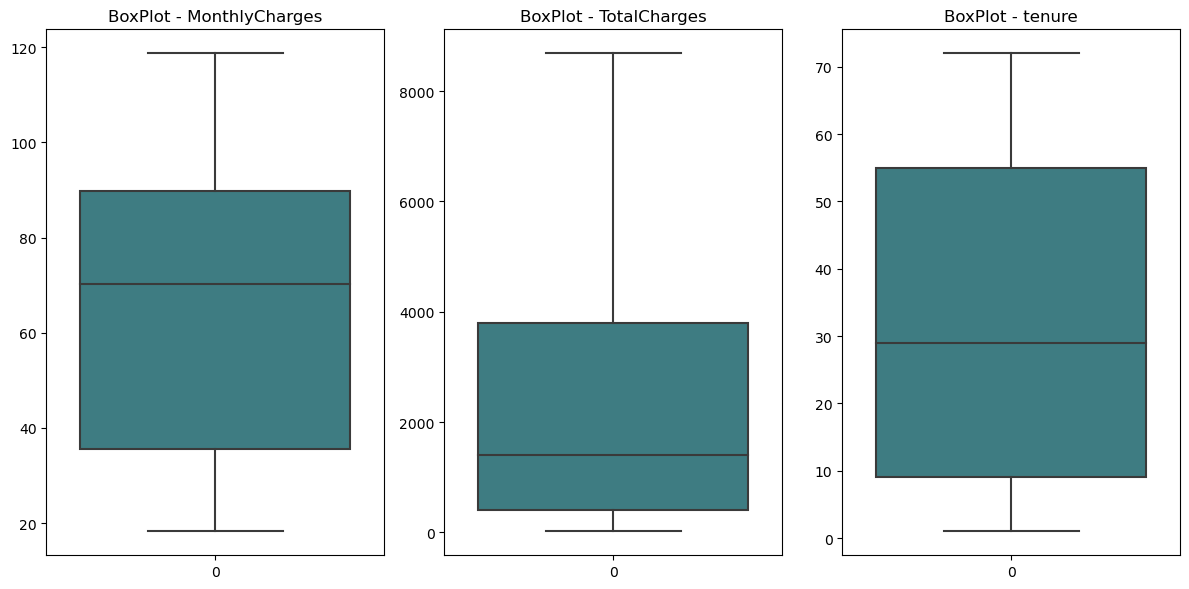

In [76]:
fig, axes = plt.subplots(1,3, figsize=(12,6))
cols = ['MonthlyCharges', 'TotalCharges', 'tenure']
for i,j in enumerate(cols):
    sns.boxplot(data = df[j], ax = axes[i], palette='crest');
    axes[i].set_title('BoxPlot - '+ j)
plt.tight_layout();

Aparentemente, não há valores *outliers*

## Atributos Categóricos

In [77]:
cat_attributes = df1.select_dtypes(include=['object'])
cat_attributes.columns

Index(['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')

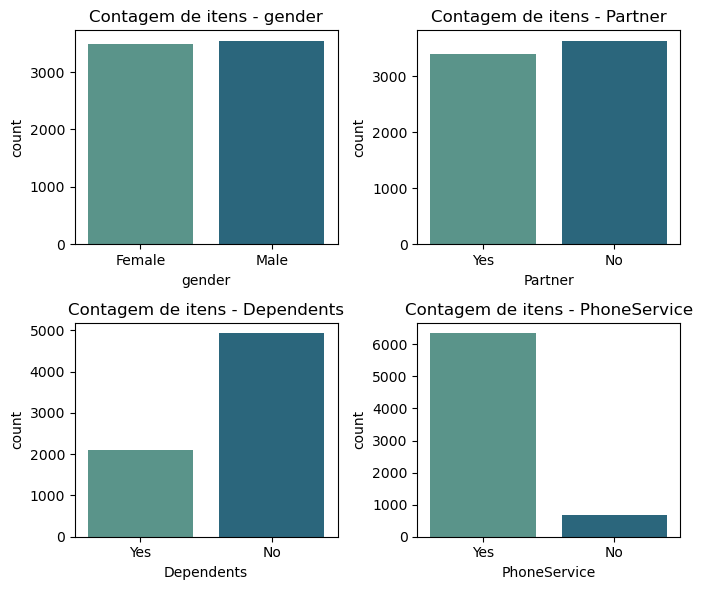

In [78]:
fig, axes = plt.subplots(2,2, figsize=(7,6))
cols = ['gender', 'Partner', 'Dependents', 'PhoneService']
for i,j in enumerate(cols):
    x,y = divmod(i, 2)
    sns.countplot(data = df1, x = j,palette='crest', ax = axes[x,y]);
    axes[x,y].set_title('Contagem de itens - '+ j)

plt.tight_layout();

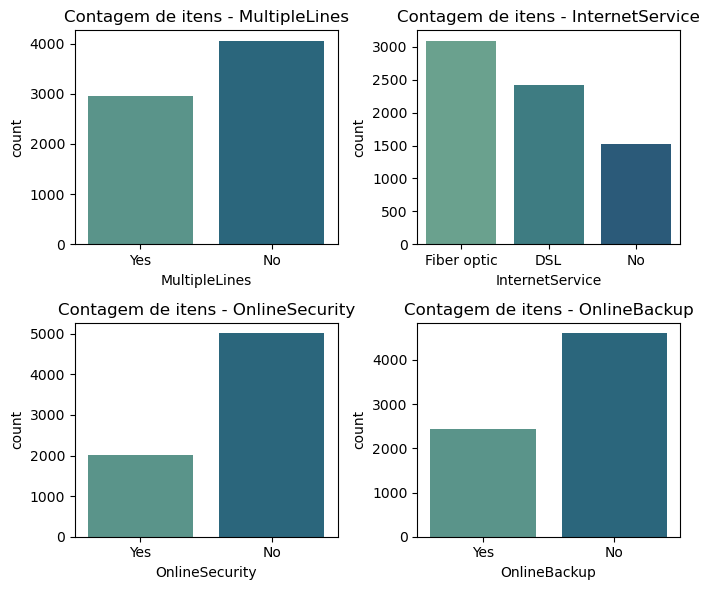

In [79]:
fig, axes = plt.subplots(2,2, figsize=(7,6))
cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup']
for i,j in enumerate(cols):
    x,y = divmod(i, 2)
    sns.countplot(data = df1, x = j, palette='crest', ax = axes[x,y]);
    axes[x,y].set_title('Contagem de itens - '+ j)

plt.tight_layout();

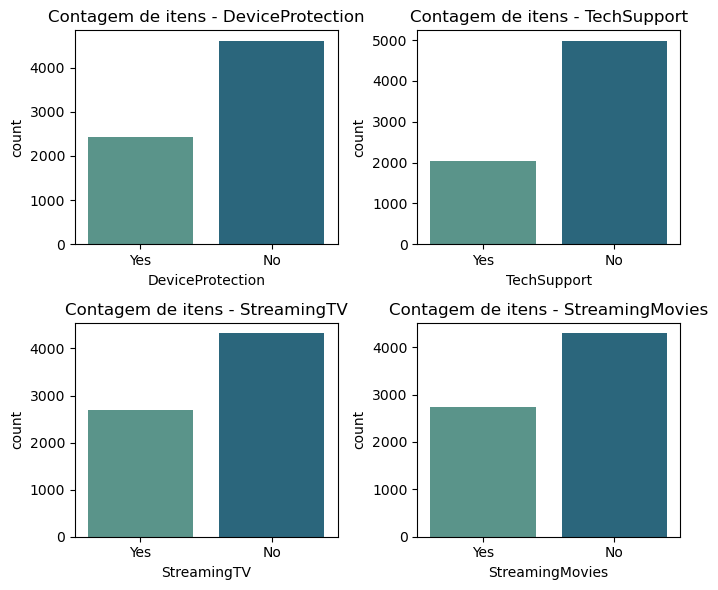

In [80]:
fig, axes = plt.subplots(2,2, figsize=(7,6))
cols = ['DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for i,j in enumerate(cols):
    x,y = divmod(i, 2)
    sns.countplot(data = df1, x = j, palette='crest', ax = axes[x,y]);
    axes[x,y].set_title('Contagem de itens - '+ j)

plt.tight_layout();

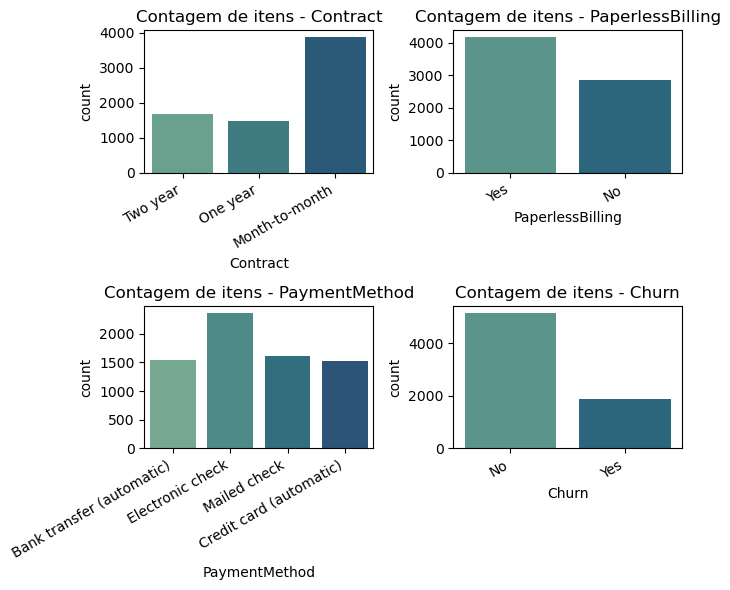

In [81]:
fig, axes = plt.subplots(2,2, figsize=(7,6))
cols = ['Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
for i,j in enumerate(cols):
    x,y = divmod(i, 2)
    sns.countplot(data = df1, x = j, palette='crest', ax = axes[x,y]);
    axes[x,y].set_title('Contagem de itens - '+ j)
    axes[x,y].set_xticklabels(axes[x,y].get_xticklabels(), rotation=30, horizontalalignment='right');

plt.tight_layout();

# Filtragem dos dados

In [82]:
df2 = df1.copy()
df2.shape

(7032, 21)

In [83]:
df2.to_parquet('../data/churn_telecom_filtered.parquet',index = False)

# Feature Engineering

In [84]:
try:
    df3 = df2.copy()
    df3.shape
except:
    df3 = pd.read_parquet('../data/raw/cardio_without_outliers.parquet')

### Quantidade de Serviços

In [85]:
df3['qtde_servicos'] = 0

cols_servicos = ['PhoneService','MultipleLines','InternetService',
                 'OnlineSecurity','OnlineBackup','DeviceProtection',
                 'TechSupport','StreamingTV','StreamingMovies']
for i in cols_servicos:
    df3.loc[df3[i] != 'No', 'qtde_servicos'] = df3['qtde_servicos'] + 1

### Tipo de Pagamento

In [86]:
df3['pagamento_automatico'] = 0
df3.loc[df3['PaymentMethod'].str.contains('automatic'), 'pagamento_automatico'] = 1

# Análise Exploratória dos dados

In [87]:
df4 = df3.copy()
df4.shape

(7032, 23)

## Plots segregados por Gênero - Contagem de features categóricas

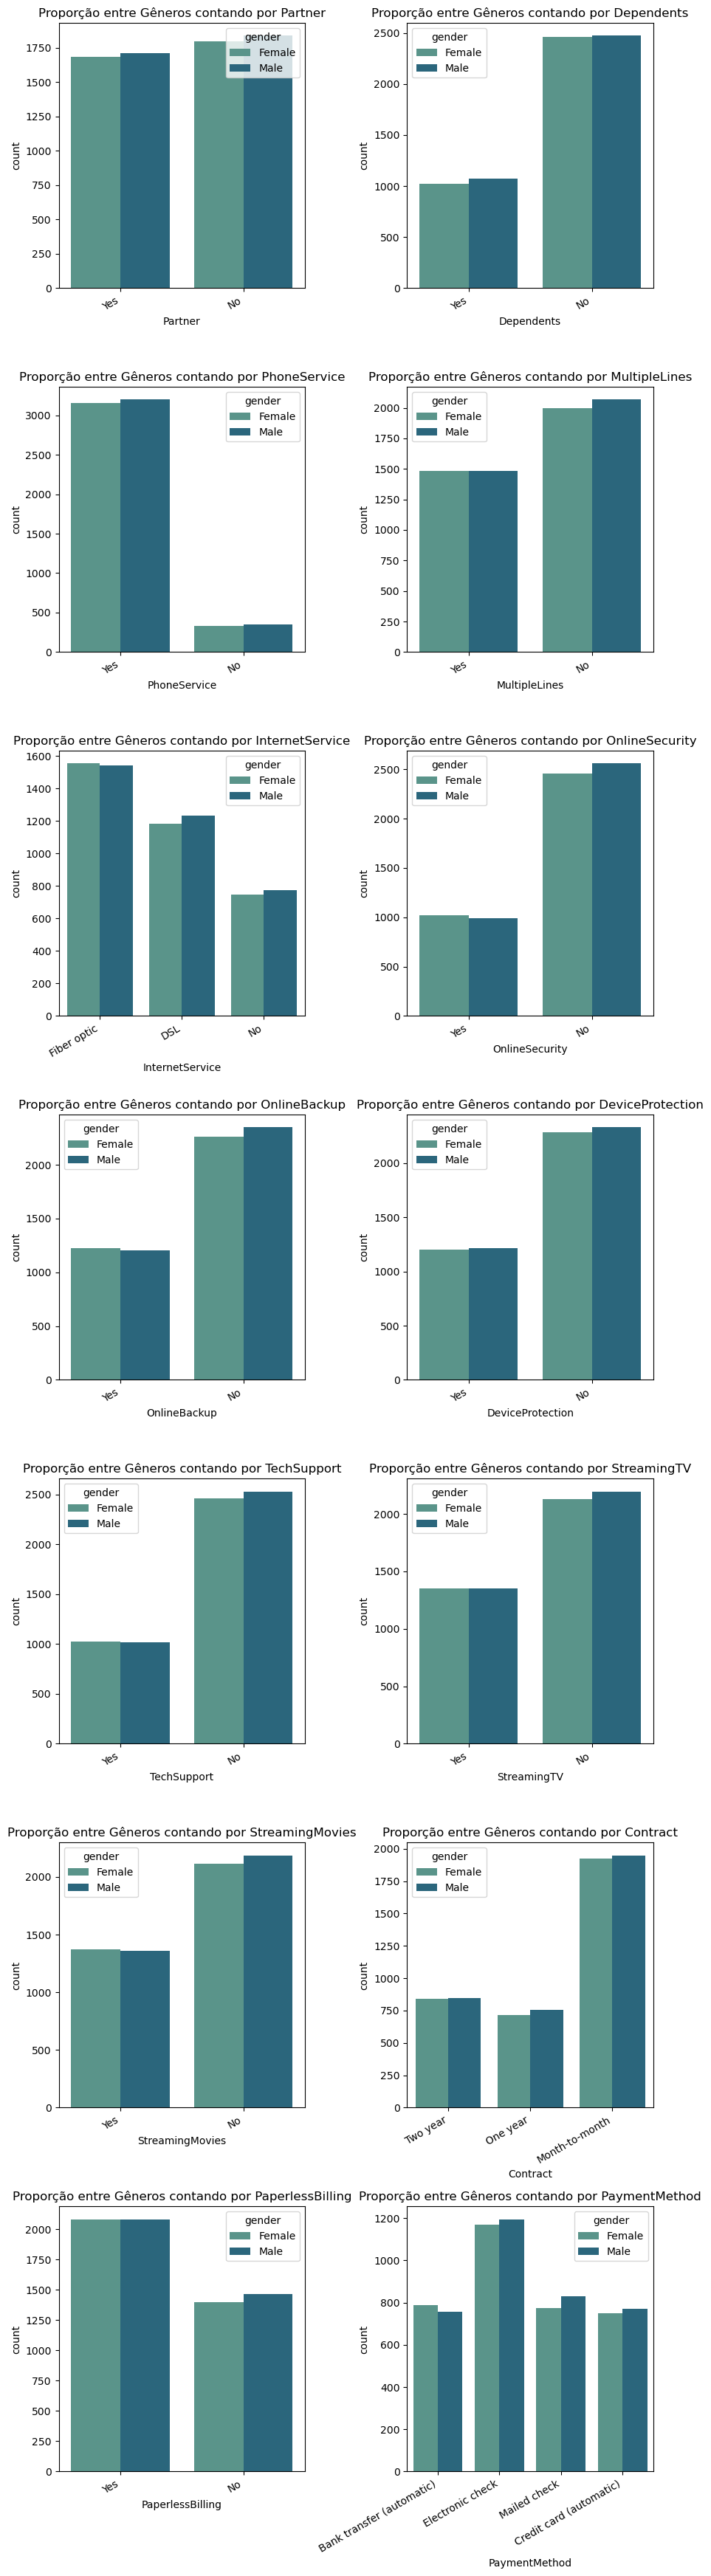

In [91]:
fig, axes = plt.subplots(7,2, figsize=(9,35))
cols = ['Partner', 'Dependents','PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod']
for i,j in enumerate(cols):
    x,y = divmod(i, 2)
    sns.countplot(data = df1, x = j,hue = 'gender', palette='crest', ax = axes[x,y]);
    axes[x,y].set_title('Proporção entre Gêneros contando por '+ j)
    axes[x,y].set_xticklabels(axes[x,y].get_xticklabels(), rotation=30, horizontalalignment='right');

plt.tight_layout();

De forma geral, a proporção de gênero é praticamente idêntica, mudando apenas a proporção entre as features comparadas.

## Plot das variáveis float segregadas por gênero

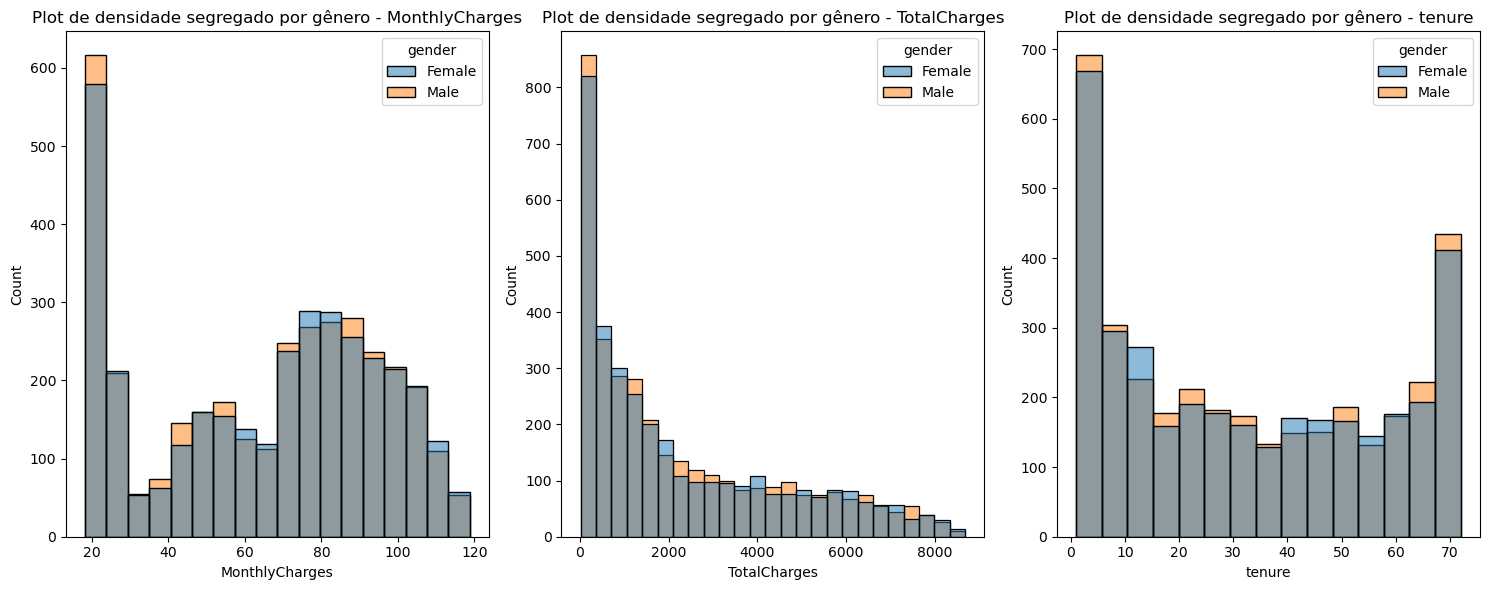

In [35]:
fig, axes = plt.subplots(1,3,figsize=(14,5))
cols = ['MonthlyCharges', 'TotalCharges','tenure']

for i,j in enumerate(cols):
    sns.histplot(data = df4,x=j, hue = 'gender', fill = True, ax = axes[i], legend = True);
    axes[i].set_title('Plot de densidade segregado por gênero - '+ j)
plt.tight_layout();

#### Aparentemente, não há diferenças significativas por gênero

## Plots MonthlyCharges x colunas categóricas

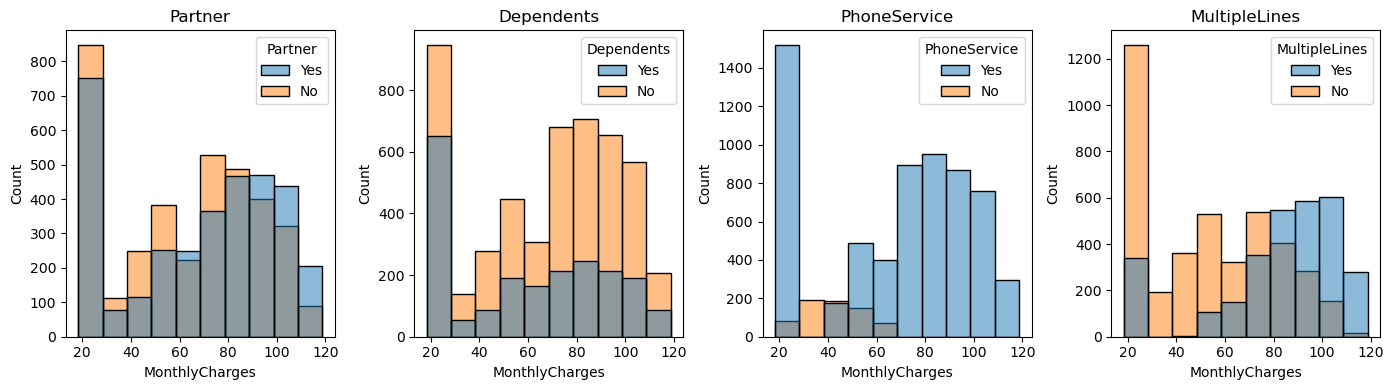

In [92]:
fig, axes = plt.subplots(1,4,figsize=(14,4))
cols = ['Partner', 'Dependents','PhoneService','MultipleLines']

for i,j in enumerate(cols):
    sns.histplot(data = df4,x='MonthlyCharges', hue = j, fill = True, ax = axes[i],bins = 10, legend = True);
    axes[i].set_title(j)
plt.tight_layout();

- #### Serviço de telefone é predominante, porém apresenta variações no preço (o que pode ser da combinação de outros serviços)
- #### Quem não tem dependentes é predominante, porém não há distinção significativa com as cobranças

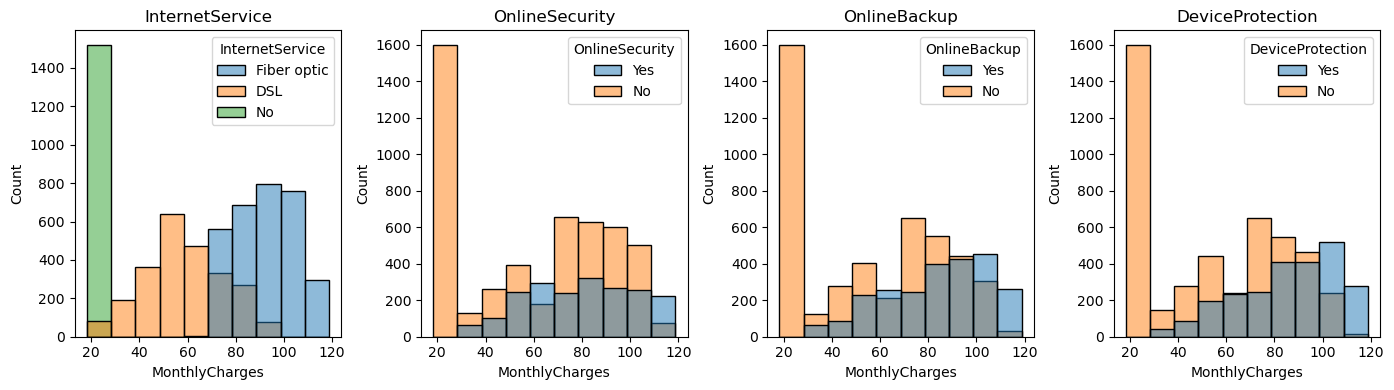

In [93]:
fig, axes = plt.subplots(1,4,figsize=(14,4))
cols = ['InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection']

for i,j in enumerate(cols):
    sns.histplot(data = df4,x='MonthlyCharges', hue = j, fill = True, ax = axes[i],bins = 10, legend = True);
    axes[i].set_title(j)
plt.tight_layout();

- #### Aparentemente, quem possui fibra ótica paga mais caro em relação a quem usa DSL
- #### Mesmo tendo grande concentração de quem não contratou Segurança Online, não há discrepância em relação à cobrança mensal
- #### O item acima vale o mesmo para Backup Online e Proteção de Dispositivo

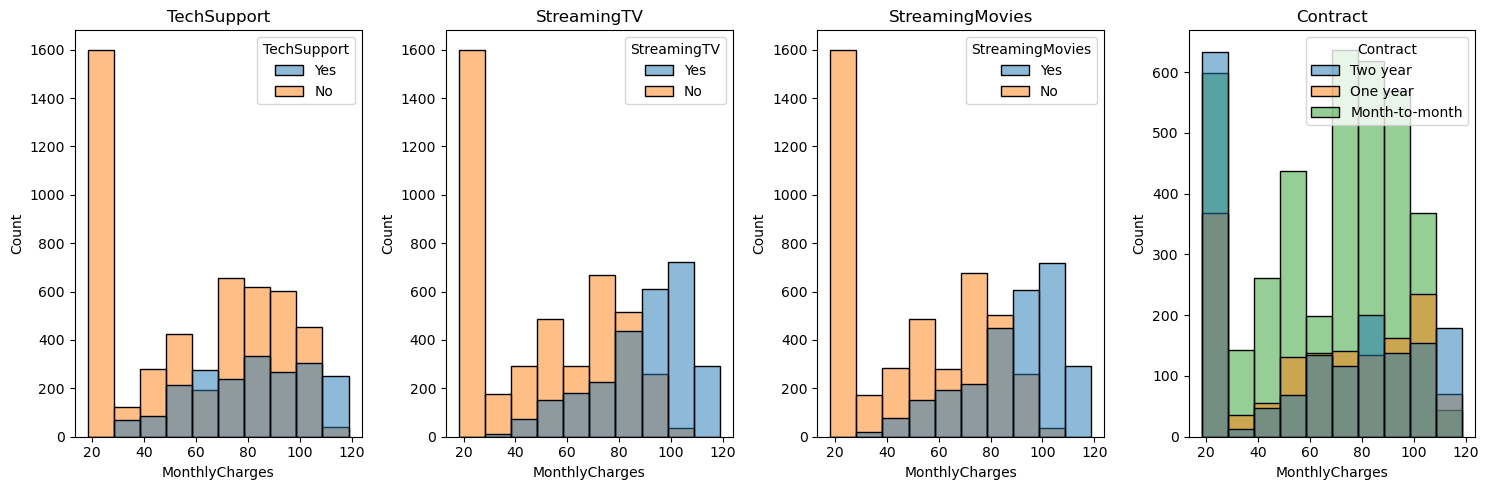

In [38]:
fig, axes = plt.subplots(1,4,figsize=(15,5))
cols = ['TechSupport','StreamingTV', 'StreamingMovies', 'Contract']

for i,j in enumerate(cols):
    sns.histplot(data = df4,x='MonthlyCharges', hue = j, fill = True, ax = axes[i],bins = 10, legend = True);
    axes[i].set_title(j)
plt.tight_layout();

- #### Aparentemente, StreamingTV e Movies tendem a gerar uma cobrança maior em relação a quem não tem
- #### Não há tanta distinção de cobrança em relação ao tipo de Contrato, apenas a concentração do tipo mesmo

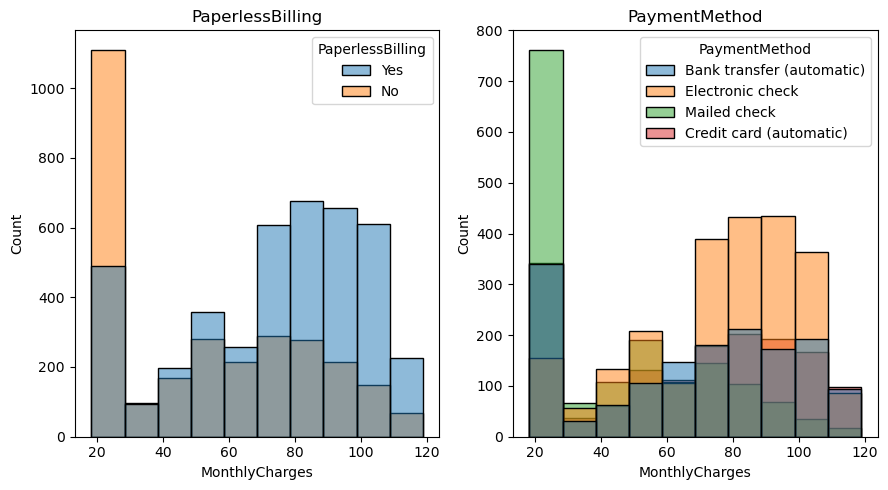

In [39]:
fig, axes = plt.subplots(1,2,figsize=(9,5))
cols = [ 'PaperlessBilling','PaymentMethod']

for i,j in enumerate(cols):
    sns.histplot(data = df4,x='MonthlyCharges', hue = j, fill = True, ax = axes[i],bins = 10, legend = True);
    axes[i].set_title(j)
plt.tight_layout();

- #### Aparentemente, quem tem conta sem ser impressa tende a pagar mais na cobrança mensal
- #### Aparentemente, quem opta por check eletrõnico tem uma ligeira cobrança maior que os demais

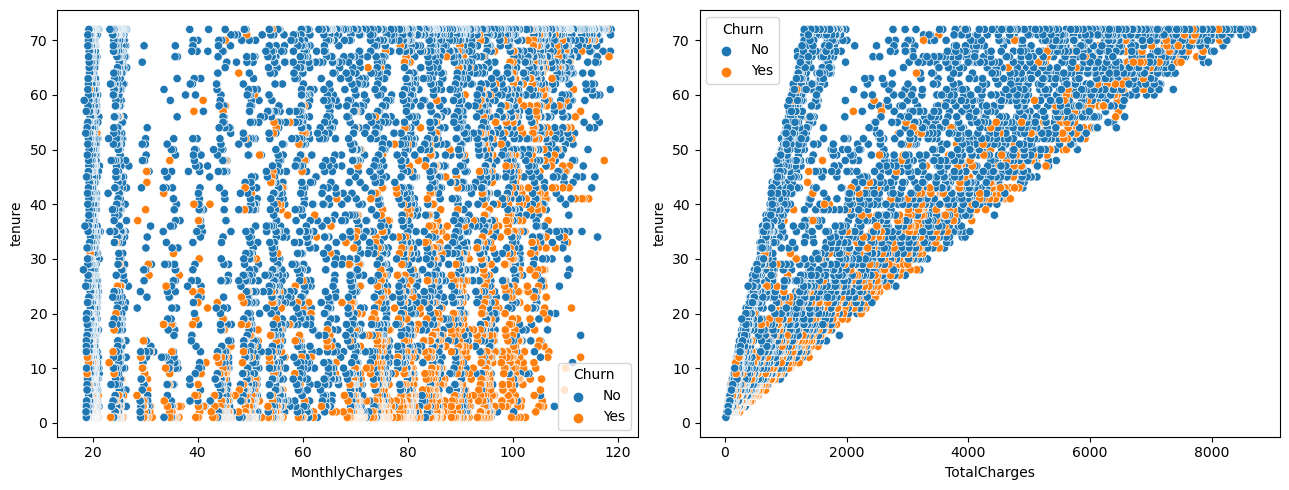

In [40]:
fig, axes = plt.subplots(1,2,figsize = (13,5))
sns.scatterplot(data = df4,x = 'MonthlyCharges',y = 'tenure', hue = 'Churn', ax = axes[0]);
sns.scatterplot(data = df4,x = 'TotalCharges',y = 'tenure', hue = 'Churn',ax = axes[1]);
plt.tight_layout();

### Aparentemente, percebe-se que quanto menor o tenure e mais alta a cobrança, mais chances de churn

## Validação Hipóteses

- H1 - Clientes com MonthlyCharges maior ou igual a média apresentam maior churn que abaixo dela
- H2 - O gênero é irrelevante para o churn
- H3 - Clientes com PaperlessBilling = 0 apresentam maior churn que quem é 1
- H4 - Contrato do tipo Mês-a-Mês é o que apresenta maior índice de churn
- H5 - Quem possui DSL como serviço de internet possui maior índice de churn
- H6 - Quem não possui dependentes tem maior índice de churn
- H7 - Quem não tem parceiro tem maior índice de churn
- H8 - Tenure abaixo da média possui maior churn que acima dela
- H9 - Quem possui método de pagamento automático tem menor índice de churn de quem não optou por esse método
- H10 - Quem possui quantidade de serviços abaixo da média tem maior índice de churn de quem está acima dela

### H1 - Clientes com MonthlyCharges maior ou igual a média apresentam maior churn que abaixo dela

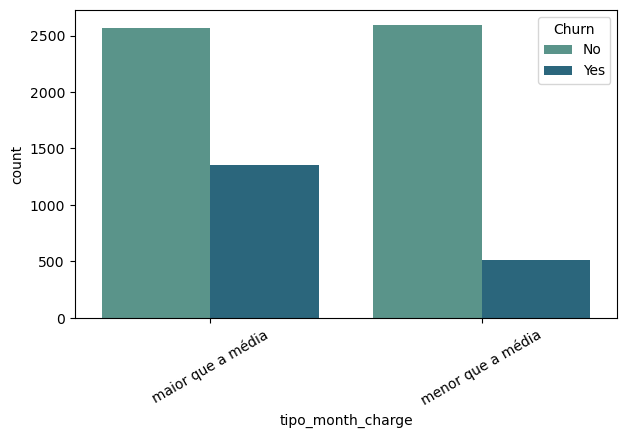

In [96]:
media_mc = df4['MonthlyCharges'].mean().round(2)

aux = df4[['MonthlyCharges','Churn']].copy()
aux['tipo_month_charge'] = 'maior que a média'
aux.loc[aux['MonthlyCharges'] < media_mc, 'tipo_month_charge'] = 'menor que a média'

fig, axes = plt.subplots(1,1,figsize=(7,4))
sns.countplot(data = aux, x = 'tipo_month_charge', hue = 'Churn', ax = axes, palette='crest');
plt.xticks(rotation = 30);

#### <font color='green'> VERDADEIRO </font> - clientes com MonthlyCharge acima da média possuem maior churn que abaixo dela

### H2 - O gênero é irrelevante para o churn

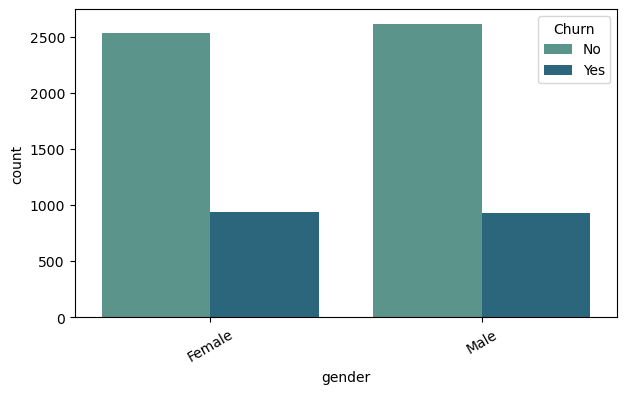

In [97]:
aux = df4.copy()

fig, axes = plt.subplots(1,1,figsize=(7,4))
sns.countplot(data = aux, x = 'gender', hue = 'Churn', ax = axes, palette='crest');
plt.xticks(rotation = 30);

#### <font color='green'>VERDADEIRO</font> - Temos praticamente a mesma proporção de Churn entre Male/Female

### H3 - Clientes com PaperlessBilling = 0 apresentam maior churn que quem é 1

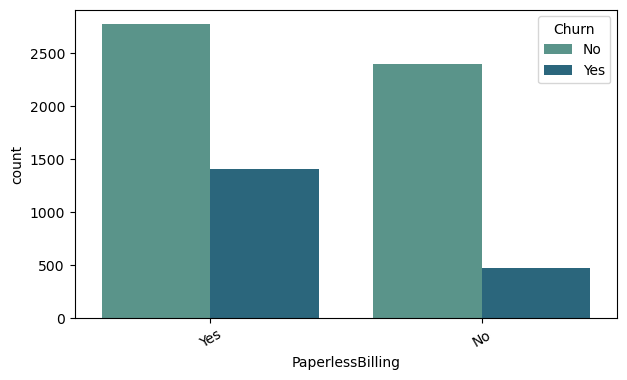

In [99]:
aux = df4.copy()

fig, axes = plt.subplots(1,1,figsize=(7,4))
sns.countplot(data = aux, x = 'PaperlessBilling', hue = 'Churn', ax = axes, palette='crest');
plt.xticks(rotation = 30);

#### <font color='red'>FALSO</font> - Quem tem PaperlessBilling = 1 possui mais chances de churn

### H4 - Contrato do tipo Mês-a-Mês é o que apresenta maior índice de churn

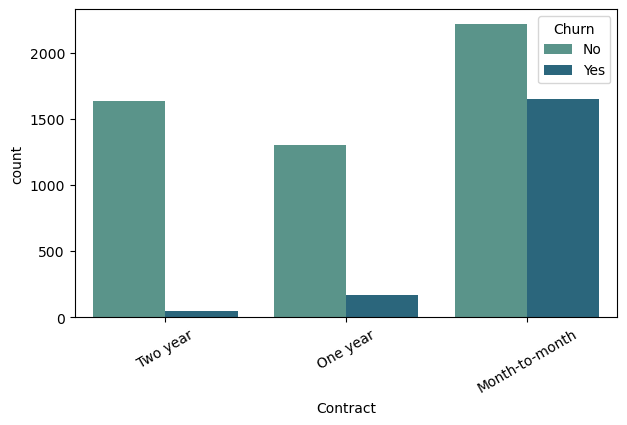

In [100]:
aux = df4.copy()

fig, axes = plt.subplots(1,1,figsize=(7,4))
sns.countplot(data = aux, x = 'Contract', hue = 'Churn', ax = axes, palette='crest');
plt.xticks(rotation = 30);

#### <font color='green'>VERDADEIRO</font> - Quem possui contrato do tipo mês-a-mês tem maiores chances de churn

### H5 - Quem possui DSL como serviço de internet possui maior índice de churn

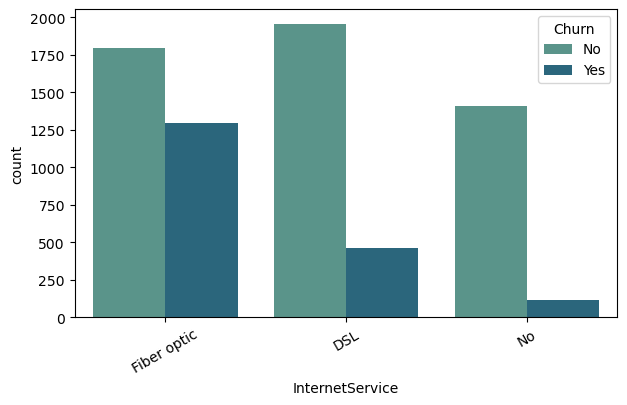

In [101]:
aux = df4.copy()

fig, axes = plt.subplots(1,1,figsize=(7,4))
sns.countplot(data = aux, x = 'InternetService', hue = 'Churn', ax = axes, palette='crest');
plt.xticks(rotation = 30);

#### <font color='red'>FALSO</font> - Quem possui mais chances de churn é quem escolhe fibra ótica

### H6 - Quem não possui dependentes tem maior índice de churn

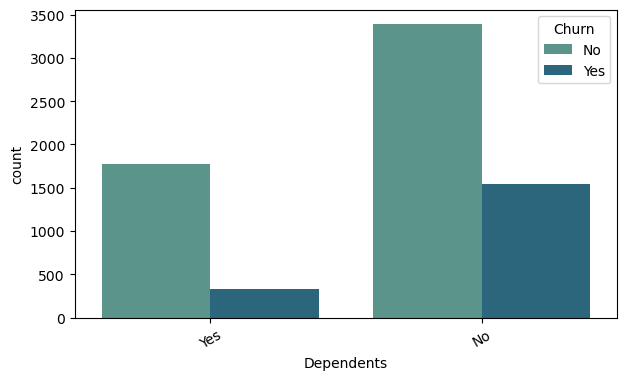

In [102]:
aux = df4.copy()

fig, axes = plt.subplots(1,1,figsize=(7,4))
sns.countplot(data = aux, x = 'Dependents', hue = 'Churn', ax = axes, palette='crest');
plt.xticks(rotation = 30);

#### <font color='green'>VERDADEIRO</font> - Quem não possui dependentes (Dependents = No) possui maiores chances de churn

### H7 - Quem não tem parceiro tem maior índice de churn

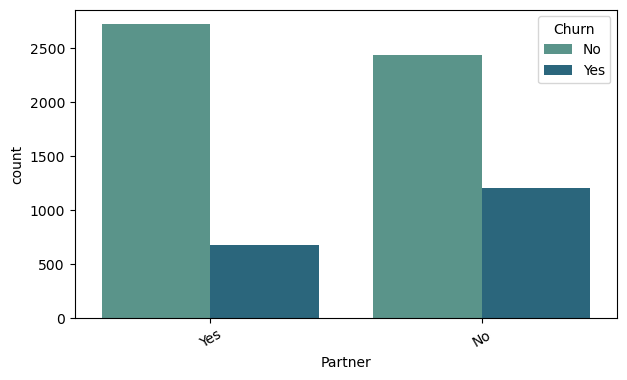

In [103]:
aux = df4.copy()

fig, axes = plt.subplots(1,1,figsize=(7,4))
sns.countplot(data = aux, x = 'Partner', hue = 'Churn', ax = axes, palette='crest');
plt.xticks(rotation = 30);

#### <font color='green'>VERDADEIRO</font> - Quem tem Partner = 0 tem mais chances de churn

### H8 - Tenure abaixo da média possui maior churn que acima dela

A média de tenure é: 32.42



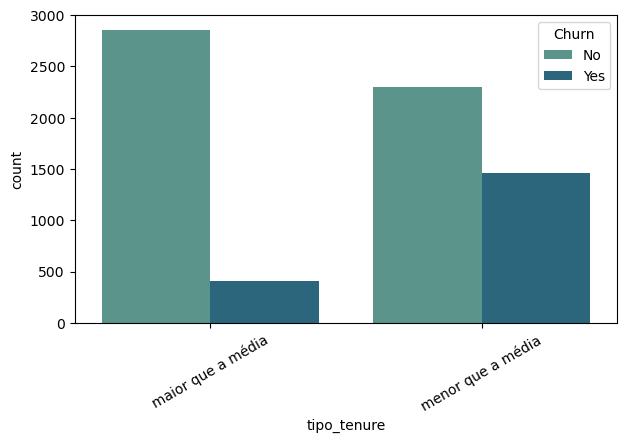

In [104]:
media_tenure = df4['tenure'].mean().round(2)
print('A média de tenure é: {}\n'.format(media_tenure))

aux = df4[['tenure','Churn']].copy()
aux['tipo_tenure'] = 'maior que a média'
aux.loc[aux['tenure'] < media_tenure, 'tipo_tenure'] = 'menor que a média'

fig, axes = plt.subplots(1,1,figsize=(7,4))
sns.countplot(data = aux, x = 'tipo_tenure', hue = 'Churn', ax = axes, palette='crest');
plt.xticks(rotation = 30);

#### <font color='green'>VERDADEIRO</font> - Quem está abaixo da média do "tenure" tem maiores chances de churn

### H9 - Quem possui método de pagamento automático tem menor índice de churn de quem não optou por esse método

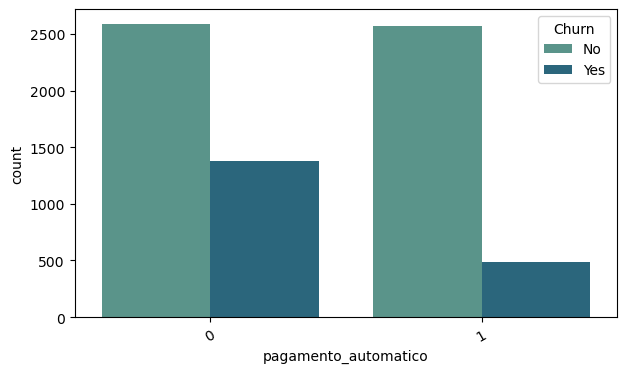

In [105]:
aux = df4.copy()

fig, axes = plt.subplots(1,1,figsize=(7,4))
sns.countplot(data = aux, x = 'pagamento_automatico', hue = 'Churn', ax = axes, palette='crest');
plt.xticks(rotation = 30);

#### <font color='green'>VERDADEIRO</font> - Quem não possui método automático tem maiores chances de churn

### H10 - Quem possui quantidade de serviços abaixo da média tem maior índice de churn de quem está acima dela

A média de serviços é: 4.0



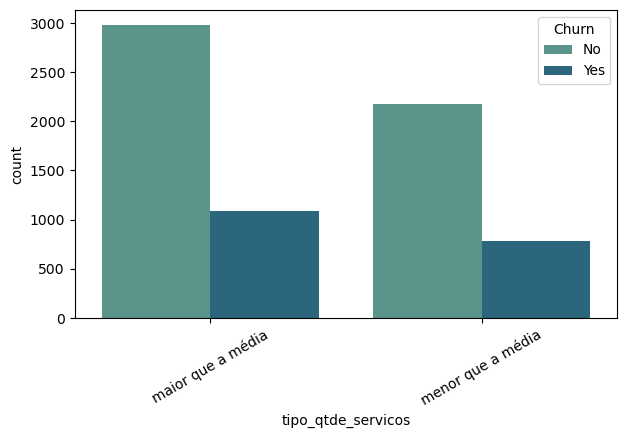

In [106]:
media_servicos = np.floor(df4['qtde_servicos'].mean())
print('A média de serviços é: {}\n'.format(media_servicos))

aux = df4[['qtde_servicos','Churn']].copy()
aux['tipo_qtde_servicos'] = 'maior que a média'
aux.loc[aux['qtde_servicos'] < media_servicos, 'tipo_qtde_servicos'] = 'menor que a média'

fig, axes = plt.subplots(1,1,figsize=(7,4))
sns.countplot(data = aux, x = 'tipo_qtde_servicos', hue = 'Churn', ax = axes, palette='crest');
plt.xticks(rotation = 30);

#### <font color='red'>FALSO</font> - Apesar de não ser uma diferença grande, quem possui serviços acima da quantidade média tem mais chances de churn

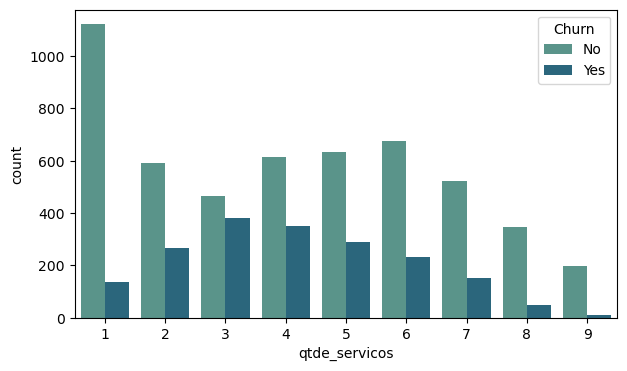

In [108]:
aux = df4.copy()

fig, axes = plt.subplots(1,1,figsize=(7,4))
sns.countplot(data = aux, x = 'qtde_servicos', hue = 'Churn', ax = axes, palette='crest');

## Análise Multivariada

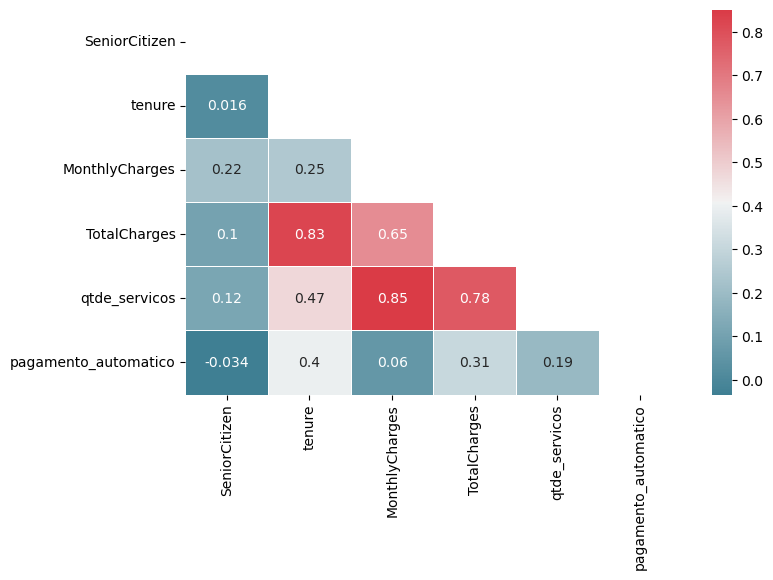

In [52]:
correlation = df4.corr(method = 'pearson').round(3)

fig, axes = plt.subplots(1,1,figsize=(8,5))

cmap = sns.diverging_palette(220, 10, as_cmap=True);
mask = np.triu(np.ones_like(correlation, dtype=bool));
sns.heatmap(correlation, cmap = cmap, mask=mask, linewidths=.5, annot=True, ax = axes);

#### Percebe-se ALTA CORRELAÇÃO entre a QTDE_SERVIÇOS e COBRANÇA MÊS/ TOTAL

## Resumo hipóteses

| ID  | Hipótese                                                                                                    | Conclusão |
|:-----:|:----------------------------------------------------------------------------------------------------------|:------------|
| H1 | Clientes com MonthlyCharges maior ou igual a média apresentam maior churn que abaixo dela                    |VERDADEIRO|
| H2 | O gênero é irrelevante para o churn                                                                          |VERDADEIRO|
| H3 | Clientes com PaperlessBilling = 0 apresentam maior churn que quem é 1                                         |FALSO|
| H4 | Contrato do tipo Mês-a-Mês é o que apresenta maior índice de churn                                            |VERDADEIRO|
 |H5 | Quem possui DSL como serviço de internet possui maior índice de churn                                         |FALSO|
| H6 | Quem não possui dependentes tem maior índice de churn                                                         |VERDADEIRO|
| H7 | Quem não tem parceiro tem maior índice de churn                                                               |VERDADEIRO|
| H8 | Tenure abaixo da média possui maior churn que acima dela                                                      |VERDADEIRO|
| H9 | Quem possui método de pagamento automático tem menor índice de churn de quem não optou por esse método        |VERDADEIRO|
| H10 | Quem possui quantidade de serviços abaixo da média tem maior índice de churn de quem está acima dela         |FALSO|

# Preparação dos dados

In [53]:
df5 = df4.copy()

print(df5.shape)

df5.head(3)

(7032, 23)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,qtde_servicos,pagamento_automatico
0,7569-NMZYQ,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),118.750,8672.450,No,9,1
1,8984-HPEMB,Female,0,No,No,71,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,118.650,8477.600,No,9,0
2,5989-AXPUC,Female,0,Yes,No,68,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Mailed check,118.600,7990.050,No,9,0


In [54]:
cols_drop = ['customerID']

df5 = df5.drop(cols_drop, axis = 1)

## Mudança Categóricos para Numéricos

In [55]:
# gender
map_gender = {'Male':1,'Female':0}
df5['gender'] = df5['gender'].map(map_gender)


# Yes/No features
cols_yes_no = [ 'Partner', 'Dependents', 'PhoneService','MultipleLines', 'OnlineSecurity', 'OnlineBackup',
               'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies','PaperlessBilling']
map_yes_no = {'Yes':1,'No':0}
for i in cols_yes_no:
    df5[i] = df5[i].map(map_yes_no)


# OneHot Encoding = ['InternetService','Contract','PaymentMethod']
cols_oh = ['InternetService','Contract','PaymentMethod']
df5 = pd.get_dummies(df5, columns = cols_oh, prefix = ['is','c','pm'])


# RobustScaler
rs = RobustScaler()
cols_rs = ['tenure', 'MonthlyCharges', 'TotalCharges']
df5[cols_rs] = rs.fit_transform(df5[cols_rs].values)
joblib.dump(rs, '../modelos/robust_scaler_churn.pkl')


# Churn
map_churn = {'Yes':1,'No':0}
df5['Churn'] = df5['Churn'].map(map_churn)

## Train/Test Split

In [56]:
X = df5.drop(['Churn'], axis = 1).copy()
y = df5[['Churn']].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

X_train.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,qtde_servicos,pagamento_automatico,is_DSL,is_Fiber optic,is_No,c_Month-to-month,c_One year,c_Two year,pm_Bank transfer (automatic),pm_Credit card (automatic),pm_Electronic check,pm_Mailed check
3218,0,1,0,0,-0.304,1,1,0,0,0,0,0,0,1,0.076,-0.074,3,0,0,1,0,1,0,0,0,0,0,1
2760,1,0,0,1,0.043,1,1,0,1,0,1,1,1,1,0.168,0.351,7,0,1,0,0,0,1,0,0,0,0,1
4516,0,0,0,0,-0.087,0,0,0,0,1,1,1,1,0,-0.298,0.008,5,0,1,0,0,0,1,0,0,0,1,0


## Balanceamento

In [57]:
print('Antes do balanceamento:')
y_train['Churn'].value_counts()

Antes do balanceamento:


0    3614
1    1308
Name: Churn, dtype: int64

In [58]:
# instancia o balanceador
resampler = SMOTETomek(random_state= 42, n_jobs=-1)

# transforms the data set
X_balanced, y_balanced = resampler.fit_resample(X_train, y_train)

In [59]:
print('Depois do balanceamento:')
y_balanced['Churn'].value_counts()

Depois do balanceamento:


1    3433
0    3433
Name: Churn, dtype: int64

In [60]:
# X_train.to_parquet('../data/X_train.parquet',index = False)
# X_test.to_parquet('../data/X_test.parquet',index = False)
# y_train.to_parquet('../data/y_train.parquet',index = False)
# y_test.to_parquet('../data/y_test.parquet',index = False)

# Seleção de features

In [61]:
# try:
#     X_train = pd.read_parquet('../data/processed/X_train.parquet')
#     X_test = pd.read_parquet('../data/processed/X_test.parquet')
#     y_train = pd.read_parquet('../data/processed/y_train.parquet')
#     y_test = pd.read_parquet('../data/processed/y_test.parquet')
# except Exception as e:
#     print(e)

## Modelagem

In [62]:
THRESHOLD = 0.5

In [63]:
# LGBM
lgbm = LGBMClassifier(random_state=42, n_jobs=2)
lgbm_metrics = model_cross_validation('lgbm', lgbm, X_train, y_train, THRESHOLD)
lgbm_metrics_balanced  = model_cross_validation('lgbm', lgbm, X_balanced, y_balanced, THRESHOLD)


# EXTRA TREES
et = ExtraTreesClassifier(n_estimators = 100,min_samples_leaf=10, max_depth=10,n_jobs = 2, random_state = 42)
et_metrics = model_cross_validation('extratrees', et, X_train, y_train, THRESHOLD)
et_metrics_balanced  = model_cross_validation('extratrees', et, X_balanced, y_balanced, THRESHOLD)


# RANDOM FOREST
rf = RandomForestClassifier(n_estimators=100,min_samples_leaf=10, max_depth=10,n_jobs = 2, random_state = 42)
rf_metrics = model_cross_validation('random_forest', rf, X_train, y_train, THRESHOLD)
rf_metrics_balanced  = model_cross_validation('random_forest', rf, X_balanced, y_balanced, THRESHOLD)


# LOGISTIC
lr_model = LogisticRegression(n_jobs = 2, random_state = 42)
lr_metrics = model_cross_validation('logistic_regression', lr_model, X_train, y_train, THRESHOLD)
lr_metrics_balanced  = model_cross_validation('logistic_regression', lr_model, X_balanced, y_balanced, THRESHOLD)


# XGB
xgb_model = XGBClassifier(n_estimators=100, max_depth=10,n_jobs = 2, random_state = 42)
xgb_metrics = model_cross_validation('xgb_classifier', xgb_model, X_train, y_train, THRESHOLD)
xgb_metrics_balanced  = model_cross_validation('xgb_classifier', xgb_model, X_balanced, y_balanced, THRESHOLD)


# KNN
knn_model = KNeighborsClassifier(n_neighbors= 10,n_jobs = 2)
knn_metrics = model_cross_validation('knn_classifier', knn_model, X_train, y_train, THRESHOLD)
knn_metrics_balanced = model_cross_validation('knn_classifier', knn_model, X_balanced, y_balanced, THRESHOLD)

### Comparison

#### Sem balanceamento

In [64]:
modeling_result = pd.concat([lgbm_metrics, et_metrics,rf_metrics, xgb_metrics, lr_metrics, knn_metrics])
modeling_result.reset_index(drop = True, inplace = True)
modeling_result.style.highlight_max(color='darkorange')

,Model Name,Precision,Recall,F1-Score,Accuracy,Kappa,AUC
0,lgbm,63.140000,51.150000,56.500000,79.050000,42.900000,82.750000
1,extratrees,66.230000,48.700000,56.110000,79.760000,43.360000,83.600000
2,random_forest,66.010000,49.470000,56.530000,79.760000,43.690000,84.020000
3,xgb_classifier,60.470000,50.690000,55.110000,78.040000,40.720000,80.700000
4,logistic_regression,64.980000,54.120000,59.020000,80.050000,45.990000,84.110000
5,knn_classifier,58.470000,43.270000,49.680000,76.720000,34.980000,79.800000


| Model Name|	Precision|	Recall|	F1-Score	|Accuracy	|Kappa	|AUC|
|:-------:|:------------:|:------:|:----------:|:----------:|:------:|:------|
|lgbm	|64.230000	|52.520000	|57.650000	|79.560000	|44.390000	|83.770000|
|extratrees	|66.790000	|49.240000	|56.510000	|79.950000	|43.900000	|84.690000|
|random_forest	|67.260000	|52.600000	|58.900000	|80.540000	|46.420000	|85.040000|
|xgb_classifier	|61.600000	|51.840000	|56.170000	|78.510000	|42.090000	|82.000000|
|logistic_regression	|65.450000	|55.350000	|59.780000	|80.290000	|46.890000	|84.940000|
|knn_classifier	|62.070000	|47.330000	|53.500000	|78.220000	|39.660000	|81.230000

#### Com balanceamento

In [65]:
modeling_result_balanced = pd.concat([lgbm_metrics_balanced , et_metrics_balanced ,rf_metrics_balanced , xgb_metrics_balanced , lr_metrics_balanced , knn_metrics_balanced ])
modeling_result_balanced.reset_index(drop = True, inplace = True)
modeling_result_balanced.style.highlight_max(color='darkorange')

,Model Name,Precision,Recall,F1-Score,Accuracy,Kappa,AUC
0,lgbm,83.780000,87.040000,85.150000,85.130000,70.260000,92.400000
1,extratrees,80.270000,84.890000,82.460000,82.040000,64.090000,90.190000
2,random_forest,80.660000,85.000000,82.730000,82.330000,64.670000,90.170000
3,xgb_classifier,84.610000,87.220000,85.590000,85.650000,71.310000,93.360000
4,logistic_regression,81.700000,84.650000,82.940000,82.870000,65.750000,91.340000
5,knn_classifier,77.910000,88.930000,83.030000,81.880000,63.760000,89.440000


| Model Name|	Precision|	Recall|	F1-Score	|Accuracy	|Kappa	|AUC|
|:-------:|:------------:|:------:|:----------:|:----------:|:------:|:------|
| lgbm	| 82.640000	| 88.150000	| 85.120000	| 84.820000	| 69.650000	| 92.770000| 
| extratrees	| 79.640000	| 85.550000	| 82.420000	| 81.820000	| 63.630000	| 90.000000| 
| random_forest	| 80.220000| 	85.860000	| 82.890000	| 82.320000	| 64.640000	| 90.140000| 
| xgb_classifier	| 84.480000	| 87.860000	| 85.860000	| 85.860000	| 71.730000	| 93.720000| 
| logistic_regression	| 81.450000	| 84.220000	| 82.600000	| 82.510000	| 65.020000	| 91.530000| 
| knn_classifier	| 77.560000	| 89.480000	| 83.040000	| 81.770000	| 63.550000	| 90.080000| 

#### Apesar do XGB apresentar boa performance no balanceamento, se olharmos a média entre Balanceado / Não balanceado e tipo de modelo, a **LogisticRegression** é a melhor escolha nessa primeira etapa

## Curva ROC

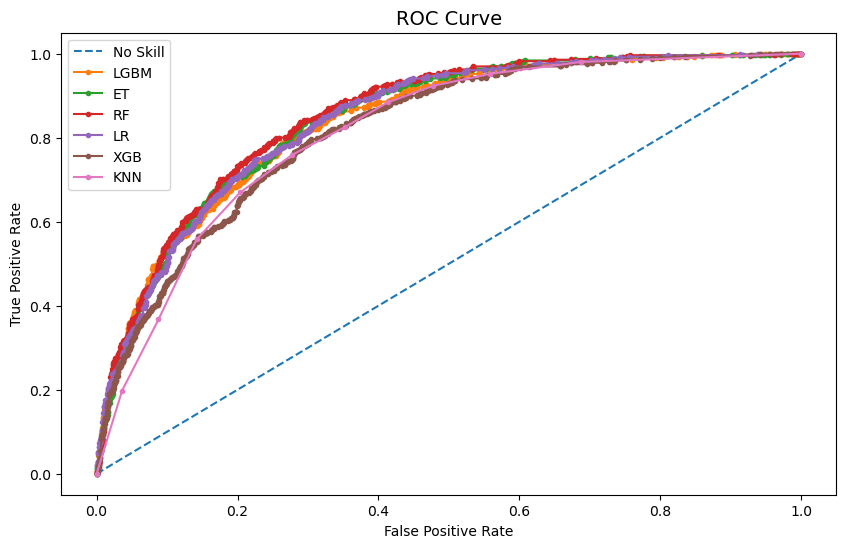

In [83]:
plt.figure(figsize=(10,6))

# criar a curva Y = X (50%)
ns_probs = [0 for _ in range(len(y_test))]

# predict das probabilidades
lgbm_probs = lgbm.predict_proba(X_test)
et_probs = et.predict_proba(X_test)
rf_probs = rf.predict_proba(X_test)
lr_probs = lr_model.predict_proba(X_test)
xgb_probs = xgb_model.predict_proba(X_test)
knn_probs = knn_model.predict_proba(X_test)


# calcular a ROC CURVE
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
fpr_lgbm, tpr_lgbm, th_lgbm = roc_curve(y_test, lgbm_probs[:,1])
fpr_et, tpr_et, th_et = roc_curve(y_test, et_probs[:,1])
fpr_rf, tpr_rf, th_rf = roc_curve(y_test, rf_probs[:,1])
fpr_lr, tpr_lr, th_lr = roc_curve(y_test, lr_probs[:,1])
fpr_xgb, tpr_xgb, th_xgb = roc_curve(y_test, xgb_probs[:,1])
fpr_knn, tpr_knn, th_knn = roc_curve(y_test, knn_probs[:,1])


# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr_lgbm, tpr_lgbm, marker='.', label='LGBM')
plt.plot(fpr_et, tpr_et, marker='.', label='ET')
plt.plot(fpr_rf, tpr_rf, marker='.', label='RF')
plt.plot(fpr_lr, tpr_lr, marker='.', label='LR')
plt.plot(fpr_xgb, tpr_xgb, marker='.', label='XGB')
plt.plot(fpr_knn, tpr_knn, marker='.', label='KNN')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# title
plt.title('ROC Curve', fontsize=14)

# show the legend
plt.legend()

# show the plot
plt.show()

In [84]:
# verificar o Threshold de acordo com uma métrica aceitavel (no caso, TPR > 0.7)
valores_lr = pd.DataFrame()
valores_lr['FPR'] = fpr_lr
valores_lr['TPR'] = tpr_lr
valores_lr['TH'] = th_lr
valores_lr.loc[valores_lr['TPR'] > 0.78].head(10)

,FPR,TPR,TH
378,0.265,0.781,0.441
379,0.274,0.781,0.433
380,0.274,0.783,0.433
381,0.277,0.783,0.430
382,0.277,0.784,0.430
383,0.278,0.784,0.429
384,0.278,0.788,0.426
385,0.285,0.788,0.416
386,0.285,0.791,0.416
387,0.287,0.791,0.413


## Curva Precisão x Recall

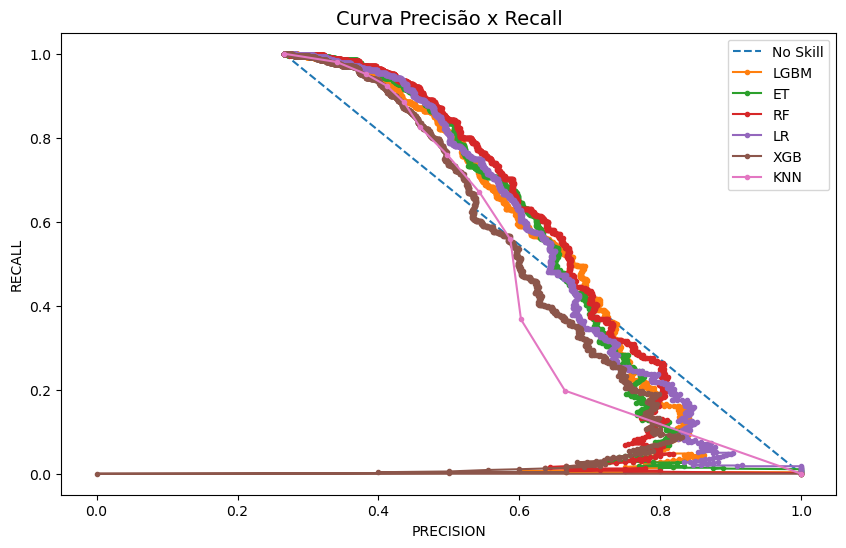

In [85]:
plt.figure(figsize=(10,6))

# criar a curva Y = X (50%)
ns_probs = [0 for _ in range(len(y_test))]

# predict das probabilidades
lgbm_probs = lgbm.predict_proba(X_test)
et_probs = et.predict_proba(X_test)
rf_probs = rf.predict_proba(X_test)
lr_probs = lr_model.predict_proba(X_test)
xgb_probs = xgb_model.predict_proba(X_test)
knn_probs = knn_model.predict_proba(X_test)


# calcular a ROC CURVE
ns_p, ns_r, _ = precision_recall_curve(y_test, ns_probs)
p_lgbm, r_lgbm, th_lgbm = precision_recall_curve(y_test, lgbm_probs[:,1])
p_et, r_et, th_et = precision_recall_curve(y_test, et_probs[:,1])
p_rf, r_rf, th_rf = precision_recall_curve(y_test, rf_probs[:,1])
p_lr, r_lr, th_lr = precision_recall_curve(y_test, lr_probs[:,1])
p_xgb, r_xgb, th_xgb = precision_recall_curve(y_test, xgb_probs[:,1])
p_knn, r_knn, th_knn = precision_recall_curve(y_test, knn_probs[:,1])


# plot the roc curve for the model
plt.plot(ns_p, ns_r, linestyle='--', label='No Skill')
plt.plot(p_lgbm, r_lgbm, marker='.', label='LGBM')
plt.plot(p_et, r_et, marker='.', label='ET')
plt.plot(p_rf, r_rf, marker='.', label='RF')
plt.plot(p_lr, r_lr, marker='.', label='LR')
plt.plot(p_xgb, r_xgb, marker='.', label='XGB')
plt.plot(p_knn, r_knn, marker='.', label='KNN')

# axis labels
plt.xlabel('PRECISION')
plt.ylabel('RECALL')

# title
plt.title('Curva Precisão x Recall', fontsize=14)

# show the legend
plt.legend()

# show the plot
plt.show()

In [91]:
# verificar o Threshold de acordo com uma métrica aceitavel (no caso, PREC ~= REC)
valores_lr = pd.DataFrame()
valores_lr['PREC'] = p_lr
valores_lr['REC'] = r_lr
valores_lr['TH'] = list(th_lr) + [1]
valores_lr.loc[valores_lr['REC'] < 0.67].head(10)

,PREC,REC,TH
1459,0.578,0.668,0.581
1460,0.577,0.667,0.582
1461,0.578,0.667,0.582
1462,0.577,0.665,0.583
1463,0.578,0.665,0.583
1464,0.579,0.665,0.583
1465,0.580,0.665,0.583
1466,0.581,0.665,0.584
1467,0.582,0.665,0.584
1468,0.583,0.665,0.586


## Validação LR sob os dados de Test

In [102]:
# THRESHOLD = 0.5
lr_model = LogisticRegression(n_jobs = 2, random_state = 42)
lr_model.fit(X_balanced,y_balanced.values)

probs = pd.DataFrame(lr_model.predict_proba(X_test)[:, 1], columns=['prob'])
y_pred = probs['prob'].apply(lambda x: 1 if x > 0.5 else 0)

confusion_matrix(y_test,y_pred)

array([[1218,  331],
       [ 158,  403]], dtype=int64)

In [103]:
print('Precisão: ',precision_score(y_test,y_pred))
print('Recall: ',recall_score(y_test,y_pred))

Precisão:  0.5490463215258855
Recall:  0.7183600713012478


In [104]:
# THRESHOLD = 0.63
lr_model = LogisticRegression(n_jobs = 2, random_state = 42)
lr_model.fit(X_balanced,y_balanced.values)

probs = pd.DataFrame(lr_model.predict_proba(X_test)[:, 1], columns=['prob'])
y_pred = probs['prob'].apply(lambda x: 1 if x > 0.63 else 0)

confusion_matrix(y_test,y_pred)

array([[1329,  220],
       [ 218,  343]], dtype=int64)

In [105]:
print('Precisão: ',precision_score(y_test,y_pred))
print('Recall: ',recall_score(y_test,y_pred))

Precisão:  0.6092362344582594
Recall:  0.6114081996434938


#### Com um THRESHOLD = 0.63, conseguimos uma métrica de RECALL / PRECISION mais BALANCEADA para a detecção de Churn

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,qtde_servicos,pagamento_automatico
0,7569-NMZYQ,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),118.750,8672.450,No,9,1
1,8984-HPEMB,Female,0,No,No,71,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,118.650,8477.600,No,9,0
2,5989-AXPUC,Female,0,Yes,No,68,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Mailed check,118.600,7990.050,No,9,0
3,5734-EJKXG,Female,0,No,No,61,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,118.600,7365.700,No,9,0
4,8199-ZLLSA,Male,0,No,No,67,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),118.350,7804.150,Yes,9,1


# Ação de possível prevenção

### Digamos que o Marketing decidiu liberar 10.000,00 para serem gastos em descontos para os prováveis clientes que entrariam em churn...

In [132]:
# pego o dataframe com os valores originais e trago o indexda porção de validação
gasto_mensal_test = df4.loc[X_test.index].copy()
gasto_mensal_test.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,qtde_servicos,pagamento_automatico
4146,7131-ZQZNK,Female,0,Yes,Yes,60,No,No,DSL,Yes,No,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),59.850,3590.200,No,6,1
5861,3373-DIUUN,Male,0,Yes,Yes,30,Yes,No,No,No,No,No,No,No,No,Two year,No,Mailed check,21.250,711.900,No,1,0
245,3518-FSTWG,Male,1,Yes,No,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),109.550,7920.700,No,8,1


In [133]:
print('Receita mensal: R$ {}'.format(gasto_mensal_test['MonthlyCharges'].sum().round(2)))

print('A média mensal: R$ {}'.format(gasto_mensal_test['MonthlyCharges'].mean().round(2)))

Receita mensal: R$ 135847.15
A média mensal: R$ 64.38


In [136]:
# adiciono as predições feitas pelo modelo LR
gasto_mensal_test['pred'] = probs

# Ordeno pelo índice de probabilidade de churn entregue pelo modelo do maior pro menor (maiores chances de churn no início)
gasto_mensal_test.sort_values(by=['pred'], ascending = False, inplace = True)
gasto_mensal_test['desconto'] = 20

# seleciono somente os top 200 para fechar a conta = 200 * 50 = 10.000
top_200 = gasto_mensal_test.head(500)

In [137]:
valor_recuperado = top_200.loc[(top_200['Churn'] == 'Yes'),'MonthlyCharges'].sum().round(2)
valor_gasto = top_200.loc[(top_200['Churn'] == 'No'),'desconto'].sum().round(2)

print('Se todos os clientes churn fossem recuperados: R$', valor_recuperado)
print('Clientes que não eram churn e foram submetidos ao desconto: R$',valor_gasto)

Se todos os clientes churn fossem recuperados: R$ 16592.45
Clientes que não eram churn e foram submetidos ao desconto: R$ 6600


In [139]:
#simulando alguns cenários

# pessimista
pessimista = (valor_recuperado * 0.6).round(2)
print('Recuperação - cenário pessimista: R$ ', pessimista)

# realista
realista = (valor_recuperado * 0.8).round(2)
print('Recuperação - cenário realista: R$ ', realista)

# otimista
otimista = (valor_recuperado * 0.9).round(2)
print('Recuperação - cenário otimista: R$ ', otimista)

#Mean
media_cenarios = ((pessimista + otimista + otimista) / 3).round(2)
print('Média dos cenários: R$ ', media_cenarios)

Recuperação - cenário pessimista: R$  9955.47
Recuperação - cenário realista: R$  13273.96
Recuperação - cenário otimista: R$  14933.21
Média dos cenários: R$  13273.96
